In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
df_movies = pd.read_csv('data/movies.csv')
df_ratings = pd.read_csv('data/ratings.csv')

In [4]:
df_ratings = df_ratings.groupby('movieId')['rating'].mean()

In [5]:
df = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10325 entries, 0 to 10324
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  10325 non-null  int64  
 1   title    10325 non-null  object 
 2   genres   10325 non-null  object 
 3   rating   10325 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 322.8+ KB
None


In [7]:
df.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.907328
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.353261
2,3,Grumpier Old Men (1995),Comedy|Romance,3.189655
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.818182
4,5,Father of the Bride Part II (1995),Comedy,3.250000


In [8]:
genres_one_hot = df['genres'].str.get_dummies(sep='|')
genres_one_hot.columns = genres_one_hot.columns.str.lower()
df['title'] = df['title'].str.lower()
df = pd.concat([df, genres_one_hot], axis=1)
df.drop('genres', axis=1, inplace=True)
df.drop('(no genres listed)', axis=1, inplace=True)

In [9]:
df.head()

,movieId,title,rating,action,adventure,animation,children,comedy,crime,documentary,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,toy story (1995),3.907328,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,jumanji (1995),3.353261,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,grumpier old men (1995),3.189655,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,waiting to exhale (1995),2.818182,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,father of the bride part ii (1995),3.250000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


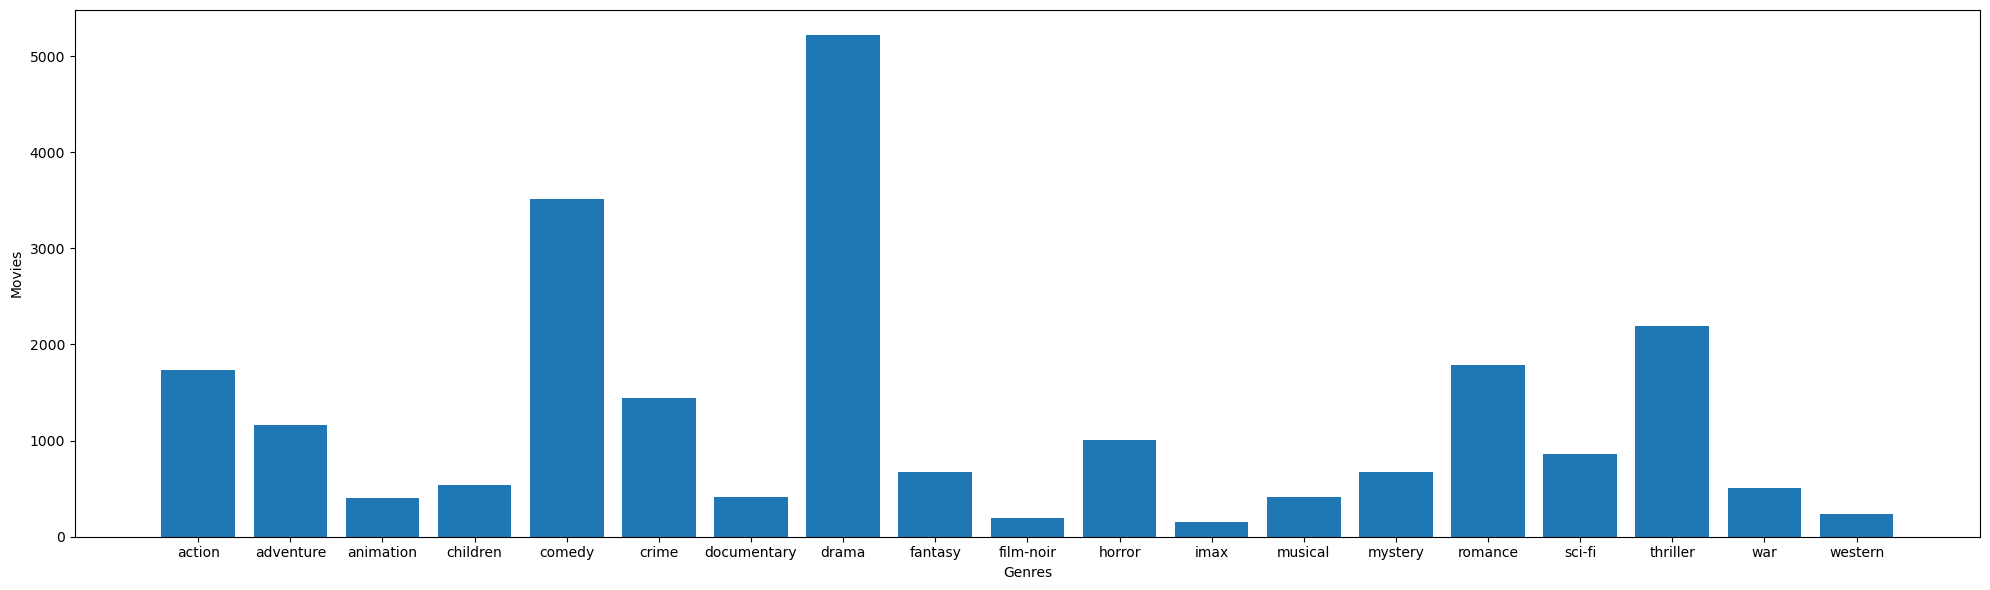

In [10]:
genre_counts = df.iloc[:, 3:].sum(axis=0)
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(genre_counts.index, genre_counts.values)
ax.set_xlabel('Genres')
ax.set_ylabel('Movies')
plt.tight_layout()
plt.show()

In [11]:
def get_recommendations_from_genres(genres, threshold_rating = 4.0):
    df_filtered = df[df[genres].apply(lambda x: any(x), axis=1)]
    df_recommendations = df_filtered[df_filtered['rating'] >= threshold_rating]
    df_recommendations = df_recommendations.sort_values(by='rating', ascending=False)
    return df_recommendations

def one_hot_to_genres(row):
    genre_columns = df.iloc[:, 3:].columns
    genres = []
    for genre in genre_columns:
        if row[genre] == 1:
            genres.append(genre)
    return '|'.join(genres)

def convert_df(df):
    genre_columns = df.iloc[:, 3:].columns

    def one_hot_to_genres(row):
        genres = []
        for genre in genre_columns:
            if row[genre] == 1:
                genres.append(genre)
        return '|'.join(genres)

    df['genres'] = df.apply(one_hot_to_genres, axis=1)
    df = df.drop(columns=genre_columns)

    return df

In [12]:
input_genres = ['comedy', 'romance']
rec = get_recommendations_from_genres(input_genres)
convert_df(rec.head(5))

C:\Users\ASUS TUFF\AppData\Local\Temp\ipykernel_9604\2187763059.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = df.apply(one_hot_to_genres, axis=1)


,movieId,title,rating,genres
10171,127052,operation 'y' & other shurik's adventures (1965),5.0,comedy|crime|romance
9085,89045,rocky vi (1986),5.0,comedy
9426,96467,sleepwalk with me (2012),5.0,comedy|drama
1495,1925,wings (1927),5.0,action|drama|romance|war
6131,26347,"irony of fate, or enjoy your bath! (ironiya su...",5.0,comedy|drama|romance


In [13]:
genre_matrix = df.iloc[:, 3:].values
linear_sim = linear_kernel(genre_matrix, genre_matrix)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [14]:
def get_recommendations_from_name(title, linear_sim=linear_sim):
    idx = indices[title]
    sim_scores = list(enumerate(linear_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [15]:
random_title = df['title'].sample().values[0]
recommendations = get_recommendations_from_name(random_title)
print('Movie title: ',random_title)
print('recommendations movies:\n',recommendations)

Movie title:  piranha ii: the spawning (1981)
recommendations movies:
 242    mary shelley's frankenstein (frankenstein) (1994)
292                         village of the damned (1995)
374                                body snatchers (1993)
456                           puppet masters, the (1994)
539                                   heavy metal (1981)
540                         hellraiser: bloodline (1996)
787                      night of the living dead (1968)
844                            lawnmower man, the (1992)
962                                        aliens (1986)
975                                         alien (1979)
Name: title, dtype: object


In [16]:
import pickle

In [17]:
with open('Movies_recommendation_objects.pkl', 'wb') as file:
    pickle.dump((linear_sim, indices, df), file)

In [18]:
with open('Movies_recommendation_objects.pkl', 'rb') as file:
    linear_sim, indices, df = pickle.load(file)

# Kiểm tra các đối tượng đã tải
print(linear_sim)
print(indices)
print(df)

[[5. 3. 1. ... 1. 0. 0.]
 [3. 3. 0. ... 0. 0. 0.]
 [1. 0. 2. ... 1. 0. 0.]
 ...
 [1. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
title
toy story (1995)                           0
jumanji (1995)                             1
grumpier old men (1995)                    2
waiting to exhale (1995)                   3
father of the bride part ii (1995)         4
                                       ...  
cosmic scrat-tastrophe (2015)          10320
le grand restaurant (1966)             10321
a very murray christmas (2015)         10322
the big short (2015)                   10323
marco polo: one hundred eyes (2015)    10324
Length: 10325, dtype: int64
       movieId                                title    rating  action  \
0            1                     toy story (1995)  3.907328       0   
1            2                       jumanji (1995)  3.353261       0   
2            3              grumpier old men (1995)  3.189655       0   
3            4         